<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/src/Token_attention_with_head_importance_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A key feature of Transformer neural networks is the attention feature. This attention is generally a sequence length x sequence length matrix output for every layer, batch and head of an input. As such, for every layer, batch, head, we can find out information about each token, whether its about what tokens a particular token attends to, or the most attended to token for each matrix. This notebook takes an example from a dataset, and explores the attentions of each token in depth. Notably, we find out what tokens each token attends to the most and what tokens that get the most attention, across all layers and heads.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

### Install and Import Dependencies

In [3]:
pip install datasets --quiet

     |████████████████████████████████| 365 kB 4.8 MB/s 
     |████████████████████████████████| 141 kB 60.6 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
     |████████████████████████████████| 212 kB 6.6 MB/s 
     |████████████████████████████████| 115 kB 56.1 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 127 kB 52.6 MB/s 


In [4]:
pip install ipywidgets --quiet

In [5]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 27.8 MB/s 


In [6]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

###Import Dataset and Model

Import the Reserach Papers dataset

In [7]:
from datasets import load_dataset
from transformers import LongformerForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

def longformer_finetuned_papers():
    test = torch.load("/content/drive/MyDrive/fakeclinicalnotes/models/full_augmented_lr2e-5_dropout3_10_trained_threshold.pt")
    model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', state_dict=test['state_dict'], num_labels = 2)
    return model

def preprocess_function(tokenizer, example, max_length):
    example['text'] = [str(x).lower() for x in example['text']]
    print(example['text'])
    example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
    return example

def get_papers_dataset(dataset_type):
    max_length = 2048
    dataset = load_dataset("danielhou13/cogs402datafake")[dataset_type]

    # tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)
    setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
    setattr(dataset, 'target_columns', ['labels'])
    setattr(dataset, 'max_length', max_length)
    setattr(dataset, 'tokenizer', tokenizer)
    return dataset

def papers_test_set():
    return get_papers_dataset('test')

def papers_train_set():
    return get_papers_dataset('train')

Load papers model and dataset and preprocess it

In [8]:
cogs402_test = papers_train_set()
model = longformer_finetuned_papers()
columns = cogs402_test.input_columns + cogs402_test.target_columns
print(columns)
cogs402_test.set_format(type='torch', columns=columns)
cogs402_test=cogs402_test.remove_columns(['text'])

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Using custom data configuration danielhou13--cogs402datafake-f5349e6cf83e41d8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402datafake-f5349e6cf83e41d8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[' start_of_record=0||||0||||  \ufeffbc children\'s hospital\tpatient loc-svc:  3m-pm  discharge summary  admitted:\t[**2020-03-05**]  (dd/mm/yyyy) discharged:\t[**2020-08-05**]  (dd/mm/yyyy)  discharge diagnoses 1.\tpolysubstance use disorder (marijuana, alcohol, opiates, stimulant (cocaine/amphetamines)). 2.\tpersistent depressive disorder, early onset, with intermittent major depressive episodes. 3.\tunspecified anxiety disorder.  medications on discharge 1.\tfluoxetine 50 mg p.o. daily. 2.\tquetiapine 50 mg p.o. t.i.d. 3.\tlisdexamfetamine 20 mg p.o. daily.   methylphenidate 90 mg p.o. q.a.m. was discontinued in hospital and lisdexamfetamine 20 mg p.o. q.a.m. was started for ongoing adhd treatment. this change was made to reduced the risk of medication diversion and misuse in hospital. a prescription was provided to [**last name (un) 1**] mother at the time of discharge for a duration of 2 weeks, with 1 available repeat (total 30 days of medication).  mental status examination at d

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['longformer_model.encoder.layer.2.intermediate.dense.weight', 'longformer_model.encoder.layer.2.attention.self.value_global.weight', 'longformer_model.encoder.layer.0.attention.self.key.bias', 'longformer_model.encoder.layer.10.attention.self.value_global.bias', 'longformer_model.encoder.layer.11.output.LayerNorm.bias', 'dense.bias', 'longformer_model.encoder.layer.1.attention.output.dense.bias', 'longformer_model.encoder.layer.8.attention.self.query.weight', 'longformer_model.encoder.layer.11.output.dense.bias', 'longformer_model.encoder.layer.1.attention.self.value_global.bias', 'longformer_model.encoder.layer.9.attention.self.key_global.weight', 'longformer_model.encoder.layer.0.output.LayerNorm.bias', 'longformer_model.encoder.layer.5.attention.self.value.weight', 'longformer_model.encoder.layer.7.intermediate.dense.bias', 'longformer_model.enco

['input_ids', 'attention_mask', 'labels']


### Get attention output for example

Don't forget to allow your model to use your GPU for faster performance.

In [9]:
if torch.cuda.is_available():
    model = model.cuda()

print(model.device)

cuda:0


You can select any example in your dataset, perferably one where you know it is interesting (like a false negative, a false positive or something that you found from a different part of your project).

In [10]:
test_val = [7]
print(test_val)
testexam = cogs402_test[test_val]

[7]


In [11]:
print(testexam["input_ids"])

tensor([[   0,  386, 1215,  ..., 1437,  114,    2]])


We stack the attentions to get an output attention tensor of shape: (layer, batch, head, seq_len, x + attention_window + 1) and a global attention tensor of shape (layer, batch, head, seq_len, x) where x is the number of global attention tokens.

In [12]:
output = model(testexam["input_ids"].cuda(), attention_mask=testexam['attention_mask'].cuda(), labels=testexam['labels'].cuda(), output_attentions = True)
batch_attn = output[-2]
output_attentions = torch.stack(batch_attn).cpu()
global_attention = output[-1]
output_global_attentions = torch.stack(global_attention).cpu()
print("output_attention.shape", output_attentions.shape)
print("gl_output_attention.shape", output_global_attentions.shape)

output_attention.shape torch.Size([12, 1, 12, 2048, 514])
gl_output_attention.shape torch.Size([12, 1, 12, 2048, 1])


In [13]:
print(testexam['labels'][0])
print(output[1].argmax())

tensor(1)
tensor(1, device='cuda:0')


In [14]:
# print(os.getcwd())
# yes = torch.load("resources/longformer_test2/epoch_3/aggregate_attn.pt")

### Convert sliding window attention to traditional format

A unique property of the longformer model is that the matrix output for the attention is not a seq_len x seq_len output. Each token can only attend to the preceeding w/2 tokens and the succeeding w/2 tokens, dictated by whatever you choose the model's attention window w to be. Another name for this is called the sliding window attention. Therefore, we need to convert sliding attention matrix to correct seq_len x seq_len matrix to remain consistent with other types of Transformer Neural Networks.

To do so, we run the following 4 functions. Our attentions will change from an output attention tensor of shape (layer, batch, head, seq_len, x + attention_window + 1) and a global attention tensor of shape (layer, batch, head, seq_len, x) to a single tensor of shape (layer, batch, head, seq_len, seq_len). More information about the functions can be found here. More information about the functions can be found [here](https://colab.research.google.com/drive/1Kxx26NtIlUzioRCHpsR8IbSz_DpRFxEZ#scrollTo=liVhkxiH9Le0).

In [15]:
def create_head_matrix(output_attentions, global_attentions):
    new_attention_matrix = torch.zeros((output_attentions.shape[0], 
                                      output_attentions.shape[0]))
    for i in range(output_attentions.shape[0]):
        test_non_zeroes = torch.nonzero(output_attentions[i]).squeeze()
        test2 = output_attentions[i][test_non_zeroes[1:]]
        new_attention_matrix_indices = test_non_zeroes[1:]-257 + i
        new_attention_matrix[i][new_attention_matrix_indices] = test2
        new_attention_matrix[i][0] = output_attentions[i][0]
        new_attention_matrix[0] = global_attentions.squeeze()[:output_attentions.shape[0]]
    return new_attention_matrix.detach().cpu().numpy()


def attentions_all_heads(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = create_head_matrix(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)


def all_batches(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = attentions_all_heads(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)

def all_layers(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = all_batches(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)

In [16]:
converted_mat_importance = all_layers(output_attentions, output_global_attentions)

Not all heads have the same impact on the final output. Some heads may be more important than others so we scale each attention matrix by their respective head and layer. The notebook used to get head importance is [here](https://colab.research.google.com/drive/1O4QCi8ewBp7asegKqySRflTQZ9HeH8mQ?usp=sharing).

In [17]:
head_importance = torch.load("/content/drive/MyDrive/fakeclinicalnotes/t3-visapplication/notes/head_importance.pt")

In [18]:
def scale_by_importance(attention_matrix, head_importance):
  new_matrix = np.zeros_like(attention_matrix)
  for i in range(attention_matrix.shape[0]):
    head_importance_layer = head_importance[i]
    for j in range(attention_matrix.shape[1]):
      new_matrix[i,j] = attention_matrix[i,j] * np.expand_dims(head_importance_layer, axis=(1,2))
  return new_matrix

In [19]:
converted_mat_importance = scale_by_importance(converted_mat_importance, head_importance)

## Assess Attention Matrix

#### Every token's top attended

Lets suppose we want the topk attended tokens for each token in each head, batch and layer. In other words, we want to know which tokens each token attends TO the most. We first need to grab the list of all tokens in our example from our input_ids as we need to display what the actual tokens are.

In [20]:
import nltk
nltk.download('stopwords')
tokenizer2 = AutoTokenizer.from_pretrained('allenai/longformer-base-4096', add_prefix_space=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.append(" ")
stopwords = set(tokenizer2.tokenize(all_stopwords, is_split_into_words =True))
stopwords.update(all_stopwords)
print(stopwords)

{'Ġyour', 'Ġfor', 'Ġmyself', "doesn't", 'were', 'Ġhave', 'she', 'n', 'than', 'between', 'over', 'Ġdon', 'on', 'very', 'Ġhasn', 'Ġme', 'Ġmore', 'Ġup', 'Ġhere', 'into', 'Ġthen', "'ve", 'Ġthrough', 'Ġany', 'Ġthis', 'Ġhim', 'Ġhadn', 'Ġshould', 'Ġaren', 'about', 'before', 'how', 'is', 'Ġoff', 'themselves', 'Ġbefore', 'both', 'theirs', 'Ġdidn', 'of', 'Ġtheirs', 'such', 'Ġve', 'their', 'Ġwill', 'have', 'we', 'Ġll', 'Ġfurther', 'Ġdoing', 'her', 'Ġitself', 'Ġcouldn', 'Ġd', "shouldn't", 'couldn', "wasn't", 'Ġthere', 'Ġthem', 'ours', 'yourself', 'Ġwhile', 'where', 'Ġinto', 'o', 'Ġa', 'hasn', "needn't", "'ll", 'once', 'Ġweren', 'yourselves', 'my', 'when', 'me', 'Ġit', 'further', 'shan', 'Ġherself', 'it', 'Ġis', 'Ġdown', 'out', 'you', 'few', 'has', 'Ġhaving', 'that', 'don', 'while', 'himself', 'why', 'Ġhimself', 'Ġonce', 'll', 'Ġain', 'Ġhas', 'Ġnor', 's', 'Ġwas', 'Ġbelow', 'Ġagain', "aren't", 'Ġmust', 'at', 'no', 'from', 'didn', 'them', 'Ġits', 'his', 'been', 'Ġourselves', 'should', 'Ġisn', 'Ġas', 

The following three functions serve to get us our top k attented tokens for each token in our attention matrix. 

`find_top_attention_unsummed` takes the full attention matrix (layer, batch, head, seq_len, seq_len) obtains the top k values for each token for every head,batch, and layer. Along with the values, it also returns the positions of each of the values so we know what token each value returned corresponds to. In other words, for every layer, for every item in the batch, for every head, it tells us for each token, what the top k tokens it attends to are. The output of the function are two matrices of shape (layer, batch, head, seq_len, k).

`get_tokens` takes in three inputs: a matrix of indices with shape (layer, batch, head, seq_len, k), the tensor of input_ids used for prediction, and an example number, and finds the associated token at each index stored in the input matrix. The example number serves only to select an example from the batch. If we do not pass in an example as an input, we will iterate over all of the batches. The output of the function is an array of shape (layer, batch, head, seq_len, k), where each item is a token from their respective example.

`highest_attended_tokens` takes in 5 inputs. It takes in a matrix of indicies, matrix of values, matrix of tokens, all with shape (layer, batch, head, seq_len, k), the tensor of input_ids used for prediction, and an example number. The example number again serves only to pick an example from the batch and if not used, will iterate over all batches. We use these matrices to create a Pandas Dataframe, where each row of the dataframe contains the current token, the position of the current token, the attended token, the position of the attended token, the attended value, the rank of the attended token w.r.t the current token, the layer, the head and the batch. 

In [22]:
# get the top k and indexes and values for each row
def find_top_attention_unsummed(scores_mat, k):
  indices = scores_mat.argsort(axis=4)[:, :, :, :, :-(k+1):-1]
  vals = np.take_along_axis(scores_mat, indices, axis=4)  
  return indices, vals

#find the tokens using the index matrix and the all_tokens list to create a 
#matrix of tokens 
def get_tokens(index_matrix, example_ids, example=None):
  
  # Make sure our example is not out of range.
  assert example < index_matrix.shape[1]

  highest_tokens = []
  #layer
  for i in range(index_matrix.shape[0]):
    row_tokens = []
    #batch
    for j in range(index_matrix.shape[1]):
      batch_tokens = []

      if (example is not None) and (j != example):
        continue

      all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])

      #head
      for k in range(index_matrix.shape[2]):
        head_tokens = []

        #token
        for x in range(index_matrix.shape[3]):
          tokens = [all_tokens[idx] for idx in index_matrix[i,j,k,x]]
          head_tokens.append(tokens)
        batch_tokens.append(head_tokens)
      row_tokens.append(batch_tokens)
    highest_tokens.append(row_tokens)
  return np.array(highest_tokens)

#format into a dataframe
def highest_attended_tokens(index, values, tokens, example_ids, example=None):
    dataframe=[]
    for i in range(index.shape[0]):
      for j in range(index.shape[1]):

        if (example is not None) and (j != example):
          continue

        all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])

        for k in range(index.shape[2]):
          for x in range(index.shape[3]):
            for y in range(index.shape[4]):
              d = {"token":all_tokens[x], 'self_position':x, 
                  "attended_token": tokens[i,j,k,x,y],
                  'token_position':index[i,j,k,x,y], 
                  'attention_scores':values[i,j,k,x,y],
                  'layer':(i+1), 'head':(k+1),
                  'rank':(y+1),
                  'batch':j}
              dataframe.append(d)
    df = pd.DataFrame(dataframe)
    return df

In [23]:
#combine the previous functions
def highest_tokens(matrix, k, example_ids, example=None):
  index, values = find_top_attention_unsummed(matrix, k)
  highest_tokens = get_tokens(index, example_ids, example)
  df = highest_attended_tokens(index, values, highest_tokens, example_ids, example)
  return df

Thus, for every token, we can get the top k tokens that this token attends to. Since it is a Dataframe, we can filter by batch, layer, head, rank, position, etc.,. The downsides are that its not very visually appealing despite being organized.

In [24]:
df2 = highest_tokens(converted_mat_importance, 10, testexam["input_ids"], 0)
df2['attended_token'] = df2['attended_token'].str.replace('Ġ', '',)

In [25]:
pd.set_option('display.max_rows', 100)
reduced_df2 = df2[(df2['attended_token'].str.isalpha()) & ~(df2['attended_token'].isin(stopwords)) & ~(df2['attention_scores']==0)]

In [26]:
reduced_df2

,token,self_position,attended_token,token_position,attention_scores,layer,head,rank,batch
0,<s>,0,parameters,1865,0.000483,1,1,1,0
1,<s>,0,without,642,0.000477,1,1,2,0
2,<s>,0,frustration,1777,0.000474,1,1,3,0
3,<s>,0,comes,1742,0.000455,1,1,4,0
6,<s>,0,became,1908,0.000434,1,1,7,0
...,...,...,...,...,...,...,...,...,...
2949109,Ġif,2046,id,1986,0.000537,12,12,10,0
2949110,</s>,2047,previously,1849,0.000623,12,12,1,0
2949112,</s>,2047,became,1908,0.000607,12,12,3,0
2949113,</s>,2047,hospital,1918,0.000598,12,12,4,0


Most ATTENDED token based on token.

In [27]:
from tqdm import tqdm
tok = []

for i in tqdm(range(df2['self_position'].max() + 1)):
  tok.extend(list(reduced_df2 [(reduced_df2 ['self_position'] == i)]["attended_token"].unique()))
token_count = np.ones(len(tok))

dict_tokens_attended = {'tokens':tok, 'count':token_count}
df_tokens_attended = pd.DataFrame(dict_tokens_attended)

aggregation_function = {'count': 'sum'}
df_tokens_attended = df_tokens_attended.groupby(df_tokens_attended['tokens']).aggregate(aggregation_function).reset_index()

100%|██████████| 2048/2048 [00:04<00:00, 488.48it/s]


In [28]:
df_tokens_attended.sort_values(by='count', ascending=False)[:25]

,tokens,count
307,one,1899.0
40,ayne,1803.0
372,respect,1796.0
37,autistic,1716.0
427,things,1697.0
169,felt,1696.0
330,per,1673.0
210,id,1664.0
381,ris,1660.0
150,events,1637.0


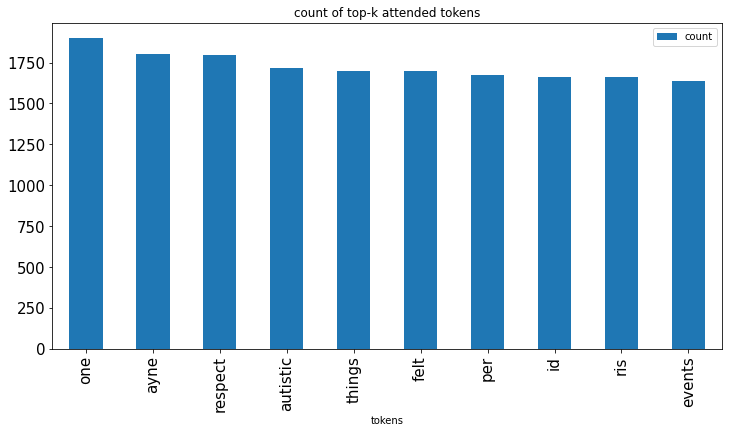

In [29]:
df_tokens_attended.sort_values(by='count', ascending=False)[:10].plot(kind='bar',x='tokens',y='count', title = "count of top-k attended tokens", figsize = (12,6), fontsize = 15)

Most Attended Token based on position ids. One potential problem with the above version is that tokens that appear multiple times in the example may be attended to much more frequently compared to other tokens. As such, there is the possibility of the count being inflated. To remedy this, instead of getting the unique attended tokens for each token, we get the attended token's position. We also grab the token associated with the position to make it more interpretable for the reader.

In [30]:
from tqdm import tqdm
tokpos = []

for i in tqdm(range(df2['self_position'].max() + 1)):
  tokpos.extend(list(reduced_df2[(reduced_df2 ['self_position'] == i)]["token_position"].unique()))

all_tokens = tokenizer.convert_ids_to_tokens(testexam["input_ids"][0])

token_count = np.ones(len(tokpos))

dict_tokpos_attended = {'token':np.array(all_tokens)[tokpos], 'token_position':tokpos, 'count':token_count}
df_tokpos_attended = pd.DataFrame(dict_tokpos_attended)
df_tokpos_attended['token'] = df_tokpos_attended['token'].str.replace('Ġ', '',) 

100%|██████████| 2048/2048 [00:04<00:00, 497.94it/s]


In [31]:
aggregation_function = {'count': 'sum'}
df_tokpos_attended = df_tokpos_attended.groupby(['token',	'token_position']).aggregate(aggregation_function).reset_index()
df_tokpos_attended.sort_values(by='count', ascending=False)[:25]

,token,token_position,count
504,ogy,1096,514.0
571,people,1551,514.0
248,entertainment,452,514.0
251,evening,528,514.0
469,misogyn,706,514.0
565,pattern,678,514.0
388,istic,707,514.0
796,trying,1733,514.0
39,appropriate,923,513.0
561,patients,1184,513.0


In [32]:
df_tokpos_attended["token (index)"] = list(zip(df_tokpos_attended['token'], df_tokpos_attended['token_position']))

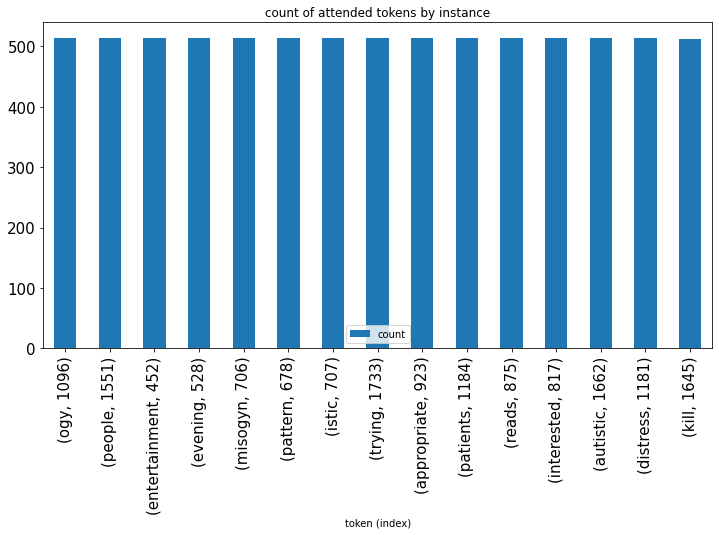

In [33]:
df_tokpos_attended.sort_values(by='count', ascending=False)[:15].plot(kind='bar',x='token (index)',y='count', title= 'count of attended tokens by instance', figsize = (12,6), fontsize = 15)

#### The Other Direction

Lets suppose we also want to find out which token attends to this token the most, as opposed to what this token attends to.

The code is functionally the same as the previous block with a few changes. The biggest change is in the find_top_attending_tokens, where we find the largest tokens in a different axis such that our outputs are now both of shape (layer, batch, head, k, seq_len), indicating that these tokens are the tokens with the highest amount of attention to this specific token.. 

However, before we pass this matrix into the next function, we swap the axes of our matrix into shape (layer, batch, head, seq_len, k) which is the same inputs that the functions above use.

Finally, we adjust the column names of our dataframe as we do not want "attended_token" this time, but rather "attending_token".

In [34]:
# get the top k and indexes and values for each row
def find_top_attending_tokens(scores_mat, k):
  indices = scores_mat.argsort(axis=3)[:, :, :, :-(k+1):-1, :]
  vals = np.take_along_axis(scores_mat, indices, axis=3)  
  return indices, vals

#find the tokens using the index matrix and the all_tokens list to create a 
#matrix of tokens 
def get_tokens_attending(index_matrix, example_ids, example=None):
  
  # Make sure our example is not out of range.
  assert example < index_matrix.shape[1]

  highest_tokens = []
  #layer
  for i in range(index_matrix.shape[0]):
    row_tokens = []
    #batch
    for j in range(index_matrix.shape[1]):
      batch_tokens = []

      if (example is not None) and (j != example):
        continue

      all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])

      #head
      for k in range(index_matrix.shape[2]):
        head_tokens = []

        #token
        for x in range(index_matrix.shape[3]):

          tokens = [all_tokens[idx] for idx in index_matrix[i,j,k,x]]
          head_tokens.append(tokens)

        batch_tokens.append(head_tokens)
      row_tokens.append(batch_tokens)
    highest_tokens.append(row_tokens)
  return np.array(highest_tokens)

#format into a dataframe
def highest_attending_tokens(index, values, tokens, example_ids, example=None):
    dataframe=[]
    for i in range(index.shape[0]):
      for j in range(index.shape[1]):

        if (example is not None) and (j != example):
          continue

        all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])

        for k in range(index.shape[2]):
          for x in range(index.shape[3]):
            for y in range(index.shape[4]):
              d = {"token":all_tokens[x], 'self_position':x, 
                  "attending_token": tokens[i,j,k,x,y],
                  'token_position':index[i,j,k,x,y], 
                  'attention_scores':values[i,j,k,x,y],
                  'layer':(i+1), 'head':(k+1),
                  'rank':(y+1),
                  'batch':j}
              dataframe.append(d)
    df = pd.DataFrame(dataframe)
    return df

In [35]:
#combine the previous functions
def highest_tokens_attending(matrix, k, example_ids, example=None):
  index, values = find_top_attending_tokens(matrix, k)
  index = index.transpose((0,1,2,4,3))
  values = values.transpose((0,1,2,4,3))
  highest_tokens = get_tokens_attending(index, example_ids, example)
  df = highest_attending_tokens(index, values, highest_tokens, example_ids, example)
  return df

In [36]:
df3 = highest_tokens_attending(converted_mat_importance, 10, testexam["input_ids"], 0)
df3['attending_token'] = df3['attending_token'].str.replace('Ġ', '',)

In [37]:
reduced_df3 = df3[(df3['attending_token'].str.isalpha()) & ~(df3['attending_token'].isin(stopwords))  & ~(df3['attention_scores']==0)]
reduced_df3

,token,self_position,attending_token,token_position,attention_scores,layer,head,rank,batch
1,<s>,0,summary,37,0.002323,1,1,2,0
3,<s>,0,abuse,18,0.002252,1,1,4,0
8,<s>,0,centre,15,0.002099,1,1,9,0
11,Ġstart,1,start,1,0.002420,1,1,2,0
13,Ġstart,1,date,75,0.002237,1,1,4,0
...,...,...,...,...,...,...,...,...,...
2949106,Ġif,2046,mother,2014,0.000428,12,12,7,0
2949108,Ġif,2046,ris,1984,0.000416,12,12,9,0
2949114,</s>,2047,ogy,2023,0.000485,12,12,5,0
2949115,</s>,2047,ĉ,2013,0.000482,12,12,6,0


Most ATTENDING tokens based on token. These blocks of code are functionally identical to the version where we get the most ATTENDED to tokens. The difference here is that we grab our unique tokens for each of our input tokens using the "attending_token" column in dataframe reduced_df3.

In [38]:
from tqdm import tqdm
tok2 = []

for i in tqdm(range(df3['self_position'].max() + 1)):
  tok2.extend(list(reduced_df3 [(reduced_df3 ['self_position'] == i)]["attending_token"].unique()))
token_count2 = np.ones(len(tok2))

dict_tokens_attending = {'tokens':tok2, 'count':token_count2}
df_tokens_attending = pd.DataFrame(dict_tokens_attending)

aggregation_function = {'count': 'sum'}
df_tokens_attending = df_tokens_attending.groupby(df_tokens_attending['tokens']).aggregate(aggregation_function).reset_index()

100%|██████████| 2048/2048 [00:04<00:00, 497.68it/s]


In [39]:
df_tokens_attending.sort_values(by='count', ascending=False)[:25]

,tokens,count
307,one,1720.0
40,ayne,1551.0
210,id,1538.0
381,ris,1528.0
330,per,1519.0
372,respect,1505.0
121,discharge,1417.0
427,things,1401.0
150,events,1351.0
284,mg,1347.0


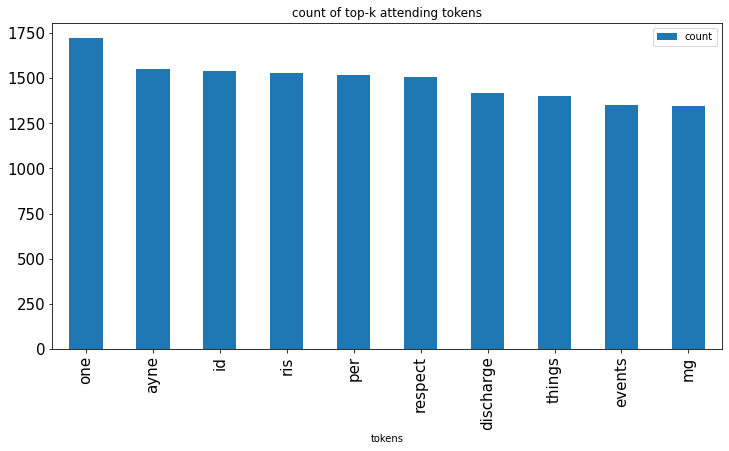

In [40]:
df_tokens_attending.sort_values(by='count', ascending=False)[:10].plot(kind='bar',x='tokens',y='count', title = "count of top-k attending tokens", figsize = (12,6), fontsize = 15)

Most ATTENDING tokens based on position ids. This is functionally identical to the above version but instead of grabbing the unique ATTENDING tokens based on what the tokens are, we get the token's position instead. However, we do make sure to get the tokens themselves so we know what the position refers to.

In [41]:
from tqdm import tqdm
tokpos2 = []

for i in tqdm(range(df3['self_position'].max() + 1)):
  tokpos2.extend(list(reduced_df3[(reduced_df3 ['self_position'] == i)]["token_position"].unique()))

all_tokens = tokenizer.convert_ids_to_tokens(testexam["input_ids"][0])

token_count2 = np.ones(len(tokpos2))

dict_tokpos_attending = {'token':np.array(all_tokens)[tokpos2], 'token_position':tokpos2, 'count':token_count2}
df_tokpos_attending = pd.DataFrame(dict_tokpos_attending)
df_tokpos_attending['token'] = df_tokpos_attending['token'].str.replace('Ġ', '',) 

100%|██████████| 2048/2048 [00:04<00:00, 510.42it/s]


We aggregate the number of times the token appears in our dataframe, but this time, by the token position rather than the token itself. We might have a lot of tokens that appear in at least one token's most ATTENDING to, so we choose to only show the top k tokens.

In [42]:
aggregation_function = {'count': 'sum'}
df_tokpos_attending = df_tokpos_attending.groupby(['token',	'token_position']).aggregate(aggregation_function).reset_index()
df_tokpos_attending.sort_values(by='count', ascending=False)[:25]

,token,token_position,count
818,wants,843,506.0
151,comments,710,505.0
561,patients,1184,503.0
172,create,749,503.0
49,asm,1297,503.0
547,p,1234,502.0
703,sharing,712,502.0
525,online,876,501.0
569,people,770,501.0
342,ias,1288,501.0


In [43]:
df_tokpos_attending["token (index)"] = list(zip(df_tokpos_attending['token'], df_tokpos_attended['token_position']))

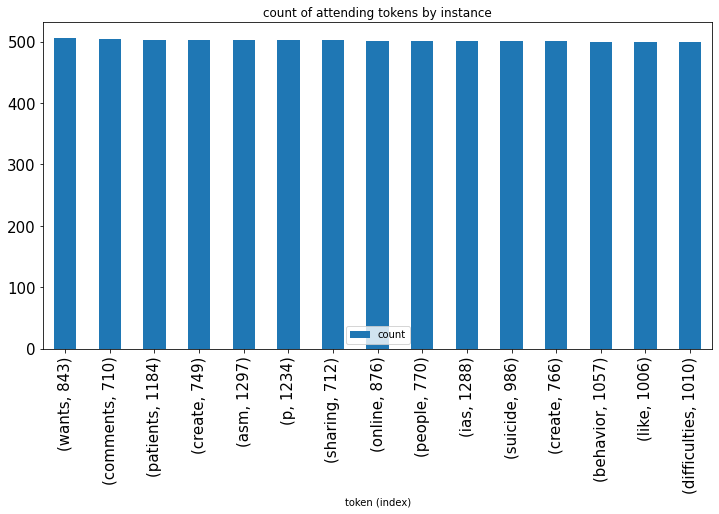

In [44]:
df_tokpos_attending.sort_values(by='count', ascending=False)[:15].plot(kind='bar',x='token (index)',y='count', title= 'count of attending tokens by instance', figsize = (12,6), fontsize=15)

#### Common Tokens

In [45]:
s1 = pd.merge(df_tokens_attended.sort_values(by='count', ascending=False)[:50], 
              df_tokens_attending.sort_values(by='count', ascending=False)[:50], 
              how='inner', on=['tokens'])
s1 = s1.rename(columns = {"count_x": "count_attended", "count_y":"count_attending"})
s1

,tokens,count_attended,count_attending
0,one,1899.0,1720.0
1,ayne,1803.0,1551.0
2,respect,1796.0,1505.0
3,autistic,1716.0,1130.0
4,things,1697.0,1401.0
5,felt,1696.0,1263.0
6,per,1673.0,1519.0
7,id,1664.0,1538.0
8,ris,1660.0,1528.0
9,events,1637.0,1351.0


In [46]:
s2 = pd.merge(df_tokpos_attended.sort_values(by='count', ascending=False)[:50], 
              df_tokpos_attending.sort_values(by='count', ascending=False)[:50], 
              how='inner', on=['token_position'])
s2 = s2.rename(columns = {"count_x": "count_attended", "count_y":"count_attending"})
s2

,token_x,token_position,count_attended,token (index)_x,token_y,count_attending,token (index)_y
0,ogy,1096,514.0,"(ogy, 1096)",ogy,495.0,"(ogy, 1096)"
1,patients,1184,513.0,"(patients, 1184)",patients,503.0,"(patients, 1184)"
2,distress,1181,513.0,"(distress, 1181)",distress,498.0,"(distress, 1181)"
3,high,1352,511.0,"(high, 1352)",high,498.0,"(high, 1352)"
4,autistic,800,510.0,"(autistic, 800)",autistic,495.0,"(autistic, 800)"
5,create,766,510.0,"(create, 766)",create,501.0,"(create, 766)"
6,powerfully,881,510.0,"(powerfully, 881)",powerfully,498.0,"(powerfully, 881)"


#### Total attention for each word

Get the sum of the attentions for all the tokens (column-wise). In other words, find out how much every word is attended to. We then normalize the values to a range of [0,1].

In [47]:
attention_matrix_importance = converted_mat_importance.sum(axis=3)
print(attention_matrix_importance.shape)

(12, 1, 12, 2048)


In [48]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [49]:
attention_matrix_importance = normalize(attention_matrix_importance)

#### PDF view

A dataframe is good for picking out information from the example, but it isn't the best being a easy to read visualization. Its easier to see how much each word is attended to in an example if we have the actual example, with the words highlighted based on the magnitude of attention.



We use https://github.com/jiesutd/Text-Attention-Heatmap-Visualization to show how much each token in the example is attended to, up to the max number of tokens we specified earlier.

In short, these functions iterate over the list of attentions and tokens, cleans the tokens to remove special characters, and normalizes the data if you wish for it to.

This notebook serves to explore one specific example in detail. If you wish to play around and/or convert multiple examples into PDFs, I recommend going to this [notebook](https://colab.research.google.com/drive/1Gyxj9rP2KnnCzit9zN3h3MeTTiQ13R7B?usp=sharing)

In [50]:
## convert the text/attention list to latex code, which will further generates the text heatmap based on attention weights.
import numpy as np

latex_special_token = ["!@#$%^&*(){}"]

def generate(text_list, attention_list, latex_file, color='red', rescale_value = True):
	assert(len(text_list) == len(attention_list))
	if rescale_value:
		attention_list = rescale(attention_list)
	word_num = len(text_list)
	text_list = clean_word(text_list)
	with open(latex_file,'w') as f:
		f.write(r'''\documentclass[varwidth]{standalone}
\special{papersize=210mm,297mm}
\usepackage{color}
\usepackage{tcolorbox}
\usepackage{CJK}
\usepackage{adjustbox}
\tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}
\begin{document}
\begin{CJK*}{UTF8}{gbsn}'''+'\n')
		string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
		for idx in range(word_num):
			string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
		string += "\n}}}"
		f.write(string+'\n')
		f.write(r'''\end{CJK*}
\end{document}''')

def rescale(input_list):
	the_array = np.asarray(input_list)
	the_max = np.max(the_array)
	the_min = np.min(the_array)
	rescale = ((the_array - the_min)/(the_max-the_min))*100
	return rescale.tolist()


def clean_word(word_list):
	new_word_list = []
	for word in word_list:
		for special_sensitive in ["\\", "^"]:
			if special_sensitive in word:
				word = word.replace(special_sensitive, '')
		for latex_sensitive in ["%", "&", "#", "_",  "{", "}"]:
			if latex_sensitive in word:
				word = word.replace(latex_sensitive, '\\' +latex_sensitive)
		new_word_list.append(word)
	return new_word_list

In [51]:
all_tokens2 = tokenizer.convert_ids_to_tokens(testexam["input_ids"][0])

Change "papers" in the following to news/whatever alternative dataset if you change the dataset used

In [52]:
average_attention = attention_matrix_importance.squeeze().sum(axis=1)
average_attention = average_attention.sum(axis=0)

We call the main function above. It takes in a list of tokens, a list of attentions, a title, and a colour. Please change "papers" to whatever your project requires.

In [53]:
title_all = f"notes_{test_val[0]}.tex"
generate(all_tokens2, (average_attention*100), title_all, 'red')

Lets suppose you don't want to find out the attentions over all layers, but just one layer. You can do that by doing one less summation and instead picking out the layer you want immediately. Here we are picking out the last layer.

In [54]:
print(attention_matrix_importance[11].squeeze().shape)
average_attention_final_layer = attention_matrix_importance[11].squeeze().sum(axis=0)

(12, 2048)


In [55]:
title_last_layer = f"notes_{test_val[0]}_layer_12_only.tex"
generate(all_tokens2, (average_attention_final_layer*100), title_last_layer, 'red')

### Highest attended tokens

Here we are getting the top k attended words for specific example in a batch, over all heads and all layers. These functions are roughly the same as the functions in the section "Every token's top attended". Here we have modified the functions as we have one less axis to deal with and rather than getting every token's top attended token, we are finding out which tokens are the most attended TO.

`find_top_attention` takes the summed attention matrix (layer, batch, head, seq_len) obtains the top k values for every head, batch, and layer. Along with the values, it also returns the positions of each value so we know what token each value returned corresponds to. The output of the function are two arrays of shape (layer, batch, head, k).

In [56]:
def find_top_attention(scores_mat, k):
  indices = scores_mat.argsort(axis=3)[:, :, :, :-(k+1):-1]
  vals = np.take_along_axis(scores_mat, indices, axis=3)
  return indices, vals

`get_tokens2` takes in three inputs: a matrix of indices with shape (layer, batch, head, k), the tensor of input_ids used for prediction, and an example number, and finds the associated token at each index stored in the input matrix. The example number serves only to select an example from the batch. If we do not pass in an example as an input, we will iterate over all of the batches. The output of the function is an array of shape (layer, batch, head, k), where each item is a token from the respective example.

In [57]:
def get_tokens2(index_matrix, example_ids, example=None):

  # Make sure our example is not out of range.
  assert example < index_matrix.shape[1]

  highest_tokens = []
  #layer
  for i in range(index_matrix.shape[0]):
    row_tokens = []
    #batch
    for j in range(index_matrix.shape[1]):
      batch_tokens = []

      if example is not None and j != example:
        continue

      all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])

      #head
      for k in range(index_matrix.shape[2]):
        tokens = [all_tokens[idx] for idx in index_matrix[i,j,k]]
        batch_tokens.append(tokens)
      row_tokens.append(batch_tokens)
    highest_tokens.append(row_tokens)
  return np.array(highest_tokens)

`highest_attended_dataframe` takes in 4 inputs. It takes in a matrix of indicies, matrix of values, matrix of tokens, all with shape (layer, batch, head, k), and an example number. The example number again serves only to pick an example from the batch and if not used, will iterate over all batches. We use these matrices to create a Pandas Dataframe, where each row of the dataframe contains the current token, the position of the current token, the value of the current token, and the rank of the token w.r.t. the current layer, head and batch. We also save the layer number, the head number and the batch in the dataframe. 

In [58]:
def highest_attended_dataframe(index, values, tokens, example=None):

    dataframe=[]
    #layer
    for i in range(index.shape[0]):
      #batch
      for j in range(index.shape[1]):
        if example is not None and j != example:
          continue
        #head
        for k in range(index.shape[2]):
          #token
          for x in range(index.shape[3]):
            d = {"token":tokens[i,j,k,x], 'position':index[i,j,k,x], 
                'attention_scores':values[i,j,k,x],
                 'layer':(i+1), 'head':(k+1),
                 'rank':(x+1),
                 'batch':j}
            dataframe.append(d)
    df = pd.DataFrame(dataframe)
    return df

Here is the function we use to wrap together our three functions above. It takes in a matrix of shape (layer, batch, head, seq_len, seq_len), a number k, the example input ids, and the example number in the batch.

In [59]:
def highest_attentions_summed(matrix, k, example_ids, example=None):
  index, values = find_top_attention(matrix, k)
  highest_tokens = get_tokens2(index, example_ids, example)
  df_highest = highest_attended_dataframe(index, values, highest_tokens, example)
  return df_highest

In [60]:
df_highest = highest_attentions_summed(attention_matrix_importance, 5, testexam["input_ids"],  0)
df_highest

,token,position,attention_scores,layer,head,rank,batch
0,<s>,0,0.450933,1,1,1,0
1,Ġthe,1790,0.202717,1,1,2,0
2,Ġwill,1793,0.189813,1,1,3,0
3,Ġhope,1788,0.189444,1,1,4,0
4,Ġmatter,735,0.184398,1,1,5,0
...,...,...,...,...,...,...,...
715,<s>,0,0.080996,12,12,1,0
716,am,263,0.038390,12,12,2,0
717,Ġthat,1789,0.038117,12,12,3,0
718,Ġhope,1788,0.037838,12,12,4,0


In [61]:
df_highest_reduced = df_highest[(df_highest['token'].str.isalpha()) & ~(df_highest['token'].isin(stopwords))  & ~(df_highest['token']==0)]
df_highest_reduced

,token,position,attention_scores,layer,head,rank,batch
3,Ġhope,1788,0.189444,1,1,4,0
4,Ġmatter,735,0.184398,1,1,5,0
6,Ġviolent,1864,0.254061,1,2,2,0
8,Ġendorsing,430,0.235338,1,2,4,0
13,Ġmom,575,0.182141,1,3,4,0
...,...,...,...,...,...,...,...
709,Ġfelt,591,0.066750,12,10,5,0
711,Ġlegitimately,1506,0.071622,12,11,2,0
714,cycl,259,0.068457,12,11,5,0
718,Ġhope,1788,0.037838,12,12,4,0


In [62]:
df_highest[df_highest["layer"]==12]['token'].value_counts()

<s>              11
,                 6
Ġto               2
Ġvery             2
oxy               2
cycl              2
Ġmel              2
Ġhope             1
Ġobviously        1
last              1
Ġname             1
1                 1
Ġdiagnosis        1
Ġp                1
Ġmisogyn          1
Ġthat             1
Ġif               1
Ġfrustration      1
Ġfelt             1
Ġlegitimately     1
Ġi                1
am                1
**                1
Ġone              1
</s>              1
Ġhe               1
Ġa                1
ĉ                 1
Ġnot              1
idal              1
Ġwhich            1
v                 1
Ġhave             1
Ġwas              1
Ġhurting          1
.                 1
Ġeither           1
Ġsaid             1
ax                1
Ġautistic         1
Name: token, dtype: int64

Using this, we could get visualizations such as seeing the trend of the topk token's attentions across layers or heads.

In [63]:
df_highest[df_highest["layer"]==12]

,token,position,attention_scores,layer,head,rank,batch
660,<s>,0,0.162182,12,1,1,0
661,Ġa,233,0.070451,12,1,2,0
662,ax,264,0.068484,12,1,3,0
663,Ġsaid,1761,0.067070,12,1,4,0
664,Ġeither,1729,0.066159,12,1,5,0
665,<s>,0,0.256802,12,2,1,0
666,.,219,0.095238,12,2,2,0
667,Ġhurting,1769,0.091742,12,2,3,0
668,Ġwas,1405,0.091698,12,2,4,0
669,Ġhave,1801,0.088331,12,2,5,0


We can visualize the results using Pandas and seaborn (extension of matplotlib) by creating the dataframe you wish to visualize and setting your x,y values with the appropriate column(s). We import ipywidgets so we have a degree of control over what visualizations we want to look at without having to constantly rerun the code. Primarily we want the select multiple widget as we have many heads and layers that we may possibly want to examine the trends for. 

**We are assuming that there is only one example in the batch.**

In [64]:
head_values = range(1,13)
layer_values = range(1,13)

import ipywidgets as widgets

ddhead = widgets.SelectMultiple(
    options=head_values,
    #rows=10,
    description='heads',
    disabled=False
)
ddlayer = widgets.SelectMultiple(
    options=layer_values,
    #rows=10,
    description='layer',
    disabled=False
)


Here we plot the trend of attentions for the topk tokens across any and all heads and any and all layers. We create a function that filters the dataframe based on the values you select and creates a lineplot to visualize the trend. You can select which head you want or what layer you want by clicking on the corresponding item in the list. The scale of the y-axis will adjust accordingly depending on your selection, but can be fixed if needed. Selecting multiple heads and layers may take a bit to process.

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

ui = widgets.HBox([ddhead,ddlayer])

def drawplot(layer, head):
  sns.set(rc = {'figure.figsize':(40,15)})

  # if you want to keep the scale consistent for any config, uncomment this line
  # plt.ylim(-0.01, 1.05)

  sns.lineplot(x= 'rank', y = "attention_scores", data=df_highest[(df_highest['layer'].isin(layer)) & (df_highest['head'].isin(head))], hue='layer', style='head', palette='viridis', legend='full')

out= widgets.interactive_output(drawplot, {'layer':ddlayer, 'head':ddhead})
display(ui,out)

Output()

#### Selective Information

We can get the attention of a token at a position for each layer and head as well as the rank of the token within that head. Take one example at a time as each example has different tokens. 

Pros: can isolate for layers and/or heads. Cons: not much context for the attention scores

`position_attention` takes in 4 inputs. It takes in a matrix of shape (layer, batch, head, seq_len), the position number you wish to look at, the tensor of input_ids used for prediction and an example number. The example number again serves only to pick an example from the batch and if not used, will iterate over all batches. We use these matrices to create a Pandas Dataframe, where each row of the dataframe contains a token, the position the token, the value of the current token, and the rank of the token w.r.t. the current layer, head and batch. We also save the layer number, the head number and the batch in the dataframe for each row. 

While this looks similar to the previous dataframe, this is restricted to what particular position you pass in as an argument and may show you tokens with a rank number higher than your threshold

In [66]:
def position_attention(agg_matrix, position, example_ids, example=None):
  dataframe = []
  # Make sure our example is not out of range.
  if example is not None:
    assert example < agg_matrix.shape[1]

  if example is not None:
    new_mat = agg_matrix[:, example, :]
    all_tokens = tokenizer.convert_ids_to_tokens(example_ids[example])
    new_mat = new_mat.squeeze()
    #layer
    for i in range(new_mat.shape[0]):
      #head
      for j in range(new_mat.shape[1]):
        temp = new_mat[i,j].argsort()[::-1]
        temp = np.where(temp==position)[0].squeeze() + 1
        d = {"token":all_tokens[position], 'position':position, 
            'attention_scores':new_mat[i,j,position], 'layer':(i+1), 'head':(j+1),
            'rank':temp, 'batch':example}
        dataframe.append(d)
  else:
    new_mat = agg_matrix
    #layer
    for i in range(new_mat.shape[0]):
      #batch
      for j in range(new_mat.shape[1]):
        all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])
        #head
        for k in range(new_mat.shape[2]):
          temp = new_mat[i,j,k].argsort()[::-1]
          temp = np.where(temp==position)[0].squeeze() + 1
          d = {"token":all_tokens[position], 'position':position, 
              'attention_scores':new_mat[i,j,k,position], 'layer':(i+1), 'head':(k+1),
              'rank':temp, 'batch':j}
          dataframe.append(d)
  df = pd.DataFrame(dataframe)
  return df

In [67]:
position_df = position_attention(attention_matrix_importance, 1782, testexam["input_ids"], 0)
position_df[position_df["head"]==9]

,token,position,attention_scores,layer,head,rank,batch
8,Ġour,1782,0.180614,1,9,51,0
20,Ġour,1782,0.166080,2,9,10,0
32,Ġour,1782,0.225110,3,9,348,0
44,Ġour,1782,0.154996,4,9,113,0
56,Ġour,1782,0.122755,5,9,653,0
68,Ġour,1782,0.129792,6,9,687,0
80,Ġour,1782,0.160851,7,9,280,0
92,Ġour,1782,0.103945,8,9,176,0
104,Ġour,1782,0.068589,9,9,217,0
116,Ġour,1782,0.092036,10,9,118,0


Here we are visualizing the attention distribution for the token at position 0 over all layers. We create a function that filters the dataframe based on the values you select and creates a scatterplot. Whatever values you selected will be displayed in the visualization. You can select which head you wish to visualize, and if you want to pick more than one, you can crtl-click or shift click to select multiple. The scale of the y-axis will adjust accordingly depending on your selection, but can be fixed if needed. Selecting multiple heads may take a bit to process.

In [68]:
ui2 = widgets.HBox([ddhead])

def drawplot2(head):
  sns.set(rc = {'figure.figsize':(35,15)})

  # if you want to keep the scale consistent for any config, uncomment this line
  # plt.ylim(-0.01, 1.05)

  sns.scatterplot(x= 'layer', y = "attention_scores", data=position_df[position_df['head'].isin(head)], hue="head", style='head', s=75, palette='viridis', legend='full')

out2= widgets.interactive_output(drawplot2, {'head':ddhead})
display(ui2,out2)

Output()

#### The Complete Package

If really needed, you can just have the full matrix of the position, ranks, attention scores, layers, and heads of each token per example. 

Pros: can search up whatever is needed. Has access to all the information and can be extracted for comparisons like the previous two dataframes.

Cons: have to know what you want and manually look it up.

`full_matrix` takes in 3 inputs. It takes in a matrix of shape (layer, batch, head, seq_len, k), the tensor of input_ids used for prediction and an example number. The example number again serves only to pick an example from the batch and if not used, will iterate over all batches. We use these matrices to create a Pandas Dataframe, where each row of the dataframe contains a token, the position the token, the value of the current token, and the rank of the token w.r.t. the current layer, head and batch. We also save the layer number, the head number and the batch in the dataframe. 

In [69]:
def full_matrix(agg_matrix, example_ids, example=None):
  dataframe=[]

  if example is not None:
    new_mat = agg_matrix[:, example]
    new_mat = new_mat.squeeze()
    print(new_mat.shape)
    all_tokens = tokenizer.convert_ids_to_tokens(example_ids[example])

    #layer
    for i in range(new_mat.shape[0]):
      #head
      for j in range(new_mat.shape[1]):
        temp = new_mat[i,j].argsort()[::-1]      
        #token
        for k in range(new_mat.shape[2]):
          temp2 = np.where(temp==k)[0].squeeze() + 1
          d = {"token":all_tokens[k], 'position':k, 
              'attention_scores':new_mat[i,j,k], 'layer':(i+1), 'head':(j+1),
              'rank':temp2}
          dataframe.append(d)
  else:
    new_mat = agg_matrix
    print(new_mat.shape)
    
    #layer
    for i in range(new_mat.shape[0]):
      #batch
      for j in range(new_mat.shape[1]):

        all_tokens = tokenizer.convert_ids_to_tokens(example_ids[j])

        #head
        for k in range(new_mat.shape[2]):
          temp = new_mat[i,j,k].argsort()[::-1]      
          #token
          for x in range(new_mat.shape[3]):
            temp2 = np.where(temp==x)[0].squeeze() + 1
            d = {"token":all_tokens[x], 'position':x, 
                'attention_scores':new_mat[i,j,k,x], 'layer':(i+1), 'head':(k+1),
                'rank':temp2, 'batch':j}
            dataframe.append(d)
  df = pd.DataFrame(dataframe)
  return df

In [70]:
full_mat = full_matrix(attention_matrix_importance, testexam["input_ids"])

(12, 1, 12, 2048)


In [71]:
full_mat[full_mat['layer']==12]

,token,position,attention_scores,layer,head,rank,batch
270336,<s>,0,0.162182,12,1,1,0
270337,Ġstart,1,0.030880,12,1,1825,0
270338,_,2,0.029125,12,1,1910,0
270339,of,3,0.027260,12,1,1984,0
270340,_,4,0.028185,12,1,1952,0
...,...,...,...,...,...,...,...
294907,Ġhim,2043,0.018041,12,12,1942,0
294908,.,2044,0.018584,12,12,1903,0
294909,Ġ,2045,0.020023,12,12,1768,0
294910,Ġif,2046,0.017389,12,12,1975,0


For this example, we look at the attention distribution for all tokens over all heads and layers. We create a function that filters the dataframe based on the values you select and creates a scatterplot. Whatever values you selected will be displayed in the visualization. You can select which head you want or what layer you want by clicking on the corresponding item in the list. Furthermore, if you want to select multiple, you can by using ctrl click or shift click. The scale of the y-axis will adjust accordingly depending on your selection, but can be fixed if needed.Selecting multiple heads may take a bit of time to process.

In [72]:
ui = widgets.HBox([ddhead,ddlayer])

def drawplotfull(layer, head):
  sns.set(rc = {'figure.figsize':(40,20)})

  # if you want to keep the scale consistent for any config, uncomment this line
  # plt.ylim(-0.01, 1.05)

  sns.scatterplot(x= 'position', y = "attention_scores", data=full_mat[(full_mat['layer'].isin(layer)) & (full_mat['head'].isin(head))], hue='layer', style='head', palette='viridis', markers=True, legend='full')

out= widgets.interactive_output(drawplotfull, {'layer':ddlayer, 'head':ddhead})
display(ui,out)


Output()

Here we show an example of how to get the top k attended tokens or filtered by position_ids like we did previously.

In [73]:
full_mat[(full_mat['rank']>=1) & (full_mat['rank'] <= 10)].sort_values(by = ['layer', 'head', 'rank'])

,token,position,attention_scores,layer,head,rank,batch
0,<s>,0,0.450933,1,1,1,0
1790,Ġthe,1790,0.202717,1,1,2,0
1793,Ġwill,1793,0.189813,1,1,3,0
1788,Ġhope,1788,0.189444,1,1,4,0
735,Ġmatter,735,0.184398,1,1,5,0
...,...,...,...,...,...,...,...
293210,1,346,0.036871,12,12,6,0
293702,Ġboth,838,0.036651,12,12,7,0
293801,Ġsuperf,937,0.036583,12,12,8,0
293110,y,246,0.036107,12,12,9,0


In [74]:
full_mat[(full_mat['position']==0)]

,token,position,attention_scores,layer,head,rank,batch
0,<s>,0,0.450933,1,1,1,0
2048,<s>,0,0.601509,1,2,1,0
4096,<s>,0,0.432398,1,3,1,0
6144,<s>,0,0.535888,1,4,1,0
8192,<s>,0,0.555162,1,5,1,0
...,...,...,...,...,...,...,...
284672,<s>,0,0.000000,12,8,2048,0
286720,<s>,0,0.275638,12,9,1,0
288768,<s>,0,0.154724,12,10,1,0
290816,<s>,0,0.143871,12,11,1,0


From here, we know how to get the visualizations for the dataframe. Slight modifications are needed to use the correct dataframe. Otherwise, you can modify the visualization to display whichever piece of information you want as there are other graphs this works on such as boxplots, histograms, piecharts, etc. 